# Cleaning simulated data and building ML model with exportable artifacts using CatalystML and TensorFlow

### Importing modules

In [1]:
%matplotlib inline

import cmlmaker as cml

import pandas as pd
import numpy as np

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import datetime as dt

## Preprocessing and creating CML artifact

### Reading in data

<p>Creating a common timestamp to use to label files throughout.</p>

In [2]:
d=dt.datetime.now()
dint=int(round(dt.datetime.timestamp(d)))

<p>Getting simulated data and inspecting properties.  Notice the catagorical, continous, and integer columns.</p>

In [3]:
filename="fin_sim_dat.csv"
df=pd.read_csv(filename)

In [4]:
df.head()

,Age,Amount,bank,cardType,entry_type,gender,transaction,v1,v2,v3,v4,fraud
0,58,20.00,Bank1,Master,chip,m,POS,1.371536,-0.588411,0.035201,-1.012560,0
1,38,0.77,Bank0,Master_Debit,chip,m,ATM,-1.278029,1.197070,1.017657,-1.650088,0
2,37,54.95,Bank5,Master_Debit,INTERNET,m,INTERNET,1.893795,-0.656074,-0.313874,0.279933,0
3,58,47.98,Bank1,Visa,chip,f,POS,2.099674,-0.872007,-0.754920,-0.599392,0
4,35,3.74,Bank10,Master,chip,f,ATM,0.400764,1.845057,-2.067862,1.757743,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Age            10000 non-null int64
Amount         10000 non-null float64
bank           10000 non-null object
cardType       10000 non-null object
entry_type     10000 non-null object
gender         10000 non-null object
transaction    10000 non-null object
v1             10000 non-null float64
v2             10000 non-null float64
v3             10000 non-null float64
v4             10000 non-null float64
fraud          10000 non-null int64
dtypes: float64(5), int64(2), object(5)
memory usage: 937.6+ KB


In [6]:
df.describe()

,Age,Amount,v1,v2,v3,v4,fraud
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,48.244800,195.033439,-0.480903,0.370074,-0.722753,0.454489,0.100000
std,17.983476,873.382584,3.251747,2.370641,3.489661,2.142095,0.300015
min,18.000000,0.000000,-30.552380,-28.097433,-31.103685,-5.560118,0.000000
25%,33.000000,7.400000,-1.108574,-0.548831,-1.252131,-0.770973,0.000000
50%,48.000000,23.375000,-0.124252,0.154989,0.004011,0.141740,0.000000
75%,64.000000,90.965000,1.263215,0.987964,0.915464,1.096716,0.000000
max,79.000000,18096.800000,2.411499,22.057729,3.971381,12.114672,1.000000


### Initializing CML structure

<p>Creating a new instance of the structure object from the CML library, with a Name, Description, and Version.  I then change the date from the default/current date.</p>

In [7]:
cs=cml.structure("FinancialStructure","Cleaning so financial data",version='1.0.1')
cs.updateCreatedDate(dt.datetime(2020,1,1).strftime("%Y%m%d"))

<p>We then need to define the data type and label for the data that is going to be coming into CML for processing.  In this case a dataframe which is represented as a map datatype in CML.</p>

In [8]:
typ="map";label="inputs"
cs=cs.addInput(cml.inobj(typ,label))

### Cleaning data and adding operations to CML

<p>Next we take  our first step in cleaning the data.  Here we normalize the Age column between 18 and 100 and the Amount column by mean+std.  First we do this using the map command in pandas.  Following that we search for the normalize operation in CML by using the python help command on the cml package and follow it by using help on cml.normalize to get the need inputs.  We then add the two normalize operations to the CML structure.</p>

In [9]:
agemin=18;agemax=100
amountscale=df.describe().loc['mean','Amount']+df.describe().loc['std','Amount']
print(amountscale)

df.Age=df.Age.map(lambda x: (x-agemin)/(agemax-agemin))
df.Amount=df.Amount.map(lambda x: (x/amountscale))

1068.416023108812


<p>Now to add the normalization steps for Age and Amount to the CML structure.  One of the ways to discover operations in CML maker is to use the python help command on the cml object.  Then we can use the help command on cml.normalize to determine what inputs we need to include.</p>

In [10]:
help(cml)

Help on module cmlmaker:

NAME
    cmlmaker

CLASSES
    builtins.object
        inobj
        operation
            add
            addCol2Table
            addPairWise
            apply
            cast
            concat
            concatMap
            contains
            count
            divPairWise
            divide
            dropCol
            flatten
            getStopWords
            grayscale
            groupBy
            ifin
            ifnotin
            img2tensor
            index
            indexany
            join
            lag
            lastindex
            levenshteinDistance
            levenshteinSimilarity
            map2table
            matchregex
            mean
            multPairWise
            multi
            norm
            normalize
            oneHotEncoding
            pivot
            posTag
            removeStop
            repeat
            replace
            replaceValue
            replaceall
            replaceregex
  

In [11]:
help(cml.normalize)

Help on class normalize in module cmlmaker:

class normalize(operation)
 |  divide all values of array by value (i.e. x/value), if minvalue is given applies (x-minval)/(value-minvalue) where x is the data
 |  
 |  Method resolution order:
 |      normalize
 |      operation
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, inputs=None, params=None, output=None)
 |      Initialize normalize operation and define inputs, parameters, and outputs
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  inputs = <class 'cmlmaker.normalize.inputs'>
 |      inputs's possible keys:
 |              data (required)- data to get mean of
 |              value (required)- value to normalize with (if starting at 0)
 |              minval (optional)- min value to start normalize with (if not starting at 0)
 |  
 |  ----------------------------------------------------------------------
 |  Methods i

In [12]:
cs=cs.addOp(
    cml.normalize(
        cml.normalize.inputs(data="$datatemp['Age']",value=agemax,minval=agemin),
        output="datatemp['Age']"
    )
)

cs=cs.addOp(
    cml.normalize(
        cml.normalize.inputs(data="$datatemp['Amount']",value=amountscale),
        output="datatemp['Amount']"
    )
)

<p>We apply this to additional data cleaning operations including replaceValue, oneHotEncoding, more normalizations.</p>

In [13]:
df.gender=df.gender.map(lambda x: 1 if x=="f" else 0)

In [14]:
cs=cs.addOp(
    cml.replaceValue(
        cml.replaceValue.inputs(data="$datatemp",replaceMap={"f":1,"m":0}),
        cml.replaceValue.params(col=["gender"]),       
        output='datatemp'
    )
)

In [15]:
cols=["bank","cardType","entry_type","transaction"]

for col in cols:
    vals=df[col].unique()
    for val in vals:
        df[val]=0
        df.loc[df[col]==val,val]=1

cs=cs.addOp(
    cml.ops.cleaning.oneHotEncoding(                                                        #operation we are adding
        cml.oneHotEncoding.inputs("$datatemp"),                                                   #OHE input object being included in op
        cml.oneHotEncoding.params(inputColumns=cols,keepOrig=True), #OHE params object being included in op
        output="datatemp"                                                                         #output label for resulting data
    )
)

print(df.columns)

Index(['Age', 'Amount', 'bank', 'cardType', 'entry_type', 'gender',
       'transaction', 'v1', 'v2', 'v3', 'v4', 'fraud', 'Bank1', 'Bank0',
       'Bank5', 'Bank10', 'Bank8', 'Bank9', 'Bank4', 'Bank7', 'Bank3', 'Bank2',
       'Bank6', 'Bank11', 'Bank12', 'Bank14', 'Bank13', 'Master',
       'Master_Debit', 'Visa', 'Visa_Debit', 'AmEx', 'chip', 'INTERNET',
       'internet', 'magnetic', 'POS', 'ATM'],
      dtype='object')


In [16]:
cols2normalize=['v1','v2','v3','v4']
vmax=5;vmin=-vmax
for col in cols2normalize:
    df[col]=df[col].map(lambda x: (x-vmin)/(vmax-vmin))

for c2n in cols2normalize:
    cs=cs.addOp(
        cml.ops.math.normalize(                                                        #operation we are adding
            cml.normalize.inputs(f"$datatemp['{c2n}']",5,-5),                                                   #OHE input object being included in op
            output=f"datatemp['{c2n}']"                                                                         #output label for resulting data
        )
    )

<p>Now we use pairwise operations to create polynomial combinations of features.</p>

In [17]:
df['v3*v4']=df.apply(lambda x: x['v3']*x['v4'],axis=1)
df['v3*v4*Visa']=df.apply(lambda x: x['v3*v4']*x['Visa'],axis=1)

df['v1*v2']=df.apply(lambda x: x['v1']*x['v2'],axis=1)
df['v1*v2*Master']=df.apply(lambda x: x['v1*v2']*x['Master'],axis=1)

In [18]:
cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v3']",
            matrix1="$datatemp['v4']"
        ),
        output="datatemp['v3*v4']"
    )
)

cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v3*v4']",
            matrix1="$datatemp['Visa']"
        ),
        output="datatemp['v3*v4*Visa']"
    )
)

cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v1']",
            matrix1="$datatemp['v2']"
        ),
        output="datatemp['v1*v2']"
    )
)

cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v1*2']",
            matrix1="$datatemp['Master']"
        ),
        output="datatemp['v1*v2*Master']"
    )
)

<p>So lots of columns where made in both the CML map variable and in the pandas df.  So here we are going to just keep the important columns.</p>

In [19]:
cols2keep=["ATM","Age","AmEx","Amount","Bank0","Bank1","Bank10","Bank2","Bank3","Bank4","Bank5","Bank6","Bank7","Bank8","Bank9","INTERNET","Master","Master_Debit","POS","Visa","Visa_Debit","chip","gender","magnetic","v1","v2","v3","v4","v1*v2*Master","v3*v4*Visa","fraud"]

dfproc=df[cols2keep]
cs=cs.addOp(
    cml.ops.restructuring.map2table(
        cml.map2table.inputs(
            "$datatemp",
            cols2keep
        ),
        output="datatab"
    )
)

<p>To finish up the CML structure object we just need to define the output.  As with above when we are referring to a variable defined in the CML scope we lead the variable name with a $.</p>

In [20]:
cs=cs.addOutput(cml.outobj("array","$datatab"))

<p>To display the final JSON we just have to print the final cml object:</p>

In [21]:
print(cs)

{
    "name": "FinancialStructure",
    "description": "Cleaning so financial data",
    "version": "1.0.1",
    "createdDate": "20200101",
    "input": [
        {
            "type": "map",
            "label": "inputs"
        }
    ],
    "structure": [
        {
            "operation": "normalize",
            "input": {
                "data": "$datatemp['Age']",
                "value": 100,
                "minval": 18
            },
            "output": "datatemp['Age']"
        },
        {
            "operation": "normalize",
            "input": {
                "data": "$datatemp['Amount']",
                "value": 1068.416023108812
            },
            "output": "datatemp['Amount']"
        },
        {
            "operation": "replaceValue",
            "input": {
                "data": "$datatemp",
                "replaceMap": {
                    "f": 1,
                    "m": 0
                }
            },
            "params": {
                "

<p>And the export the JSON we just need to call the writeToFile method of the cml structurte.</p>

In [22]:
cs.writeToFile(f'findata_{dint}.json')

In [23]:
dfproc.values.shape

(10000, 31)

### Building a Tensorflow  model

<p>Now that we have created the CML JSON object for exporting for deployment lets use the cleaned data to create a TF1.X model that we can also export and zip together.  We have created a 15% test set with the remaing being used for training.  The training set then has 15% saved for evaluation during training.  We create a 5 layer dense NN for our model and train for 50 epochs.  This yeilds a precision of ~90% and recall of about 70%.  If the layers are increase to (32,16,4,2,1) * numinps, with the same 2 outputs the precision / recall becomes ~80% /~85% greatly increasing recall at the cost of precision.</p>

<p>Here we aren't going to go into further detail in building a model or exploring more features for accuracy.  Links concerning these topics are in the medium article.</p>

In [24]:
df=dfproc


In [25]:
cols=[col for col in df.columns if col not in ["fraud"]]
len(cols)

30

In [26]:
dftrain,dftest=train_test_split(df,test_size=0.15)

In [27]:
numinps= len(cols)
numinps

30

In [28]:
dftrain2,dfeval=train_test_split(dftrain,test_size=0.15)

In [29]:
#encodedim=28
numclasses=2
#hiddim=encodedim//2
lr=0.001 #learnrate=tf.placeholder(tf.float32, name='learningrate')
droprate=0.2 #tf.placeholder(tf.float32, name='droprate')
inputs=tf.placeholder(tf.float64, shape=(None,numinps),name="inputs")
mode=tf.placeholder(tf.string, name="mode")
labels=tf.placeholder(tf.int32,shape=(None),name='labels')

dense0 = tf.layers.dense(inputs=inputs, units=numinps*8, activation=tf.nn.relu)
dropout0 = tf.layers.dropout(inputs=dense0, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense1 = tf.layers.dense(inputs=dropout0, units=numinps*4, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense1a = tf.layers.dense(inputs=dropout1, units=numinps*3, activation=tf.nn.relu)
dropout1a = tf.layers.dropout(inputs=dense1a, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense2 = tf.layers.dense(inputs=dropout1a, units=numinps*2, activation=tf.nn.relu)
dropout2 = tf.layers.dropout(inputs=dense2, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense3 = tf.layers.dense(inputs=dropout2, units=numinps*1, activation=tf.nn.relu)
dropout3 = tf.layers.dropout(inputs=dense3, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense4 = tf.layers.dense(inputs=dropout3, units=numclasses)#, activation=tf.nn.relu)
logits = tf.layers.dropout(inputs=dense4, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)
Yprobab=tf.nn.softmax(logits,name='Yprobab')
Yout = tf.argmax(Yprobab,1)

#loss=tf.losses.mean_squared_error(labels=inputs,predictions=dropout4)
#loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=labels)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels)
batchloss=tf.reduce_mean(loss)
trainstep=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)


W0130 13:41:15.798857 140736061952896 deprecation.py:323] From <ipython-input-29-016c16180561>:10: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0130 13:41:15.806589 140736061952896 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0130 13:41:16.166506 140736061952896 deprecation.py:323] From <ipython-input-29-016c16180561>:11: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [30]:
init = tf.global_variables_initializer()
batchsize=100
#xbatch=dftrain2.loc[:,cols].head(10).values
evalbatch=dfeval[cols]
evallabels=dfeval["fraud"]
numepochs=50
#d=dt.datetime.now() (moved above to keep timestamp consistent)
#dint=int(round(dt.datetime.timestamp(d)))
savedir=f"./m_{dint}"

treerr=[]
everr=[]

report_it=50
eval_it=report_it*5

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(numepochs):
        for i in range(dftrain2.shape[0]//batchsize):
            xbatch=dftrain2.iloc[i*batchsize:(i+1)*batchsize][cols].values
            lab=dftrain2.iloc[i*batchsize:(i+1)*batchsize]['fraud']
            _,ltr=sess.run([trainstep,batchloss],feed_dict={inputs:xbatch,labels:lab})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.TRAIN})
            if i%(eval_it//5)==0:
                l=sess.run([batchloss],feed_dict={inputs:evalbatch,labels:evallabels})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.EVAL})
                treerr.append(ltr)
                everr.append(l)
            
            if i%report_it==0 and i>0:
                print("train: ",epoch,i,ltr)
            if i%eval_it==0  and i>0:
                print("evalu: ",epoch,i,l[0])
    print("evalu: ",epoch,i,l[0])
    
    print("Running Test data...")
    #out=[]
    if 1:
    #for i in range(dftest.shape[0]):
        testbatch=np.array(dftest.iloc[:][cols].values)
        testlabels=np.array(dftest.iloc[:]['fraud'].values)
        l,yout=sess.run([batchloss,Yout],feed_dict={inputs:testbatch,labels:testlabels})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.EVAL})
        #out.append()
        dfout2=pd.DataFrame(data={"label":dftest.iloc[:]['fraud'].values,"err":l,"pred":yout})
    tf.saved_model.simple_save(sess,savedir, inputs=
                           {
                               "inputs":inputs#,'labels':labels,"learnrate":learnrate,"droprate":droprate,"mode":mode
                           },
                           outputs={"Yout":Yout}#,"batchloss":batchloss}
                          )


train:  0 50 0.05691616956478315
train:  1 50 0.04064253520085033
train:  2 50 0.0370756264298536
train:  3 50 0.0383629123989286
train:  4 50 0.03639309483886397
train:  5 50 0.03758069899663139
train:  6 50 0.03795157629935992
train:  7 50 0.03726641273088682
train:  8 50 0.04220765852557426
train:  9 50 0.03436477782769483
train:  10 50 0.02307430831691697
train:  11 50 0.02530109496249938
train:  12 50 0.03157001358465952
train:  13 50 0.014967907386223327
train:  14 50 0.00920760324630899
train:  15 50 0.01635877408288684
train:  16 50 0.01734300913103167
train:  17 50 0.013423485584042619
train:  18 50 0.0063313169675134695
train:  19 50 0.0046465910641818485
train:  20 50 0.004088251769555511
train:  21 50 0.02943489682666032
train:  22 50 0.02045941096538303
train:  23 50 0.008986969492791945
train:  24 50 0.02544559809865637
train:  25 50 0.026223933636711664
train:  26 50 0.017579615571297363
train:  27 50 0.01656040086424948
train:  28 50 0.015585374878913299
train:  29 50 0

W0130 13:41:42.361599 140736061952896 deprecation.py:323] From <ipython-input-30-3601283fca38>:49: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
W0130 13:41:42.362705 140736061952896 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


train:  49 50 0.002316308838306837
evalu:  49 71 0.27101999758857165
Running Test data...


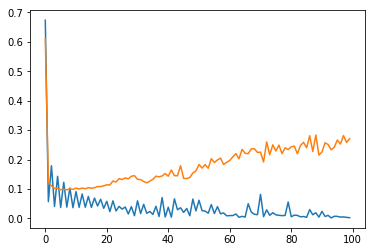

In [31]:
plt.plot(treerr)
plt.plot(everr)
plt.show()


In [32]:
def prec_recall(df):
    '''Assumes columns of pred and label'''
    tp=df[(df['label']==1)&(df['pred']==1)].shape[0]#number of true positives
    recall = tp/df['label'].sum()                   #recall
    prec =   tp/df['pred'].sum()                    #precision
    fp=df[(df['label']!=1)&(df['pred']==1)].shape[0]#number of false positives
    fpr=fp/df['pred'].sum()                         #False positive rate
    return prec,recall,fpr

prec2,recall2,fpr2=prec_recall(dfout2)
print("DNNClassifier prec {:5.3f}, recall {:5.3f}, fpr {:5.3f}".format(prec2,recall2,fpr2))


DNNClassifier prec 0.863, recall 0.869, fpr 0.137


<p>Zipping up the model files into a single Archive, that can be directly loaded into Flogo.</p>

In [33]:
s=f"cd {savedir}; zip Archive_{dint}.zip sav* var*; mv Arch* ../.; cd .."
os.system(s)
stream = os.popen(s)
output = stream.read()
outlines=output.strip().rsplit("\n")
for line in outlines:
    print(line.strip())

adding: saved_model.pb (deflated 88%)
adding: variables/ (stored 0%)


In [34]:
df.loc[df['fraud']==1,:].shape[0]/df.shape[0]

0.1

In [35]:
len(df)

10000